In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import sys
# Load database path from functions_env module
sys.path.append('../')
from functions_env import DB_PATH

# Establish a connection to the SQLite database
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Load data from 'individual_wikipedia' table
data_proxies = pd.read_sql_query("SELECT * FROM individual_wikipedia", conn)

# Filter and transform data for analysis
df = data_proxies[['individual_wikidata_id', 'created_at']].dropna()
df['creation_year'] = df['created_at'].apply(lambda x: x[:4]).astype(str)
df = df.drop('created_at', axis=1)

### Plot the graph

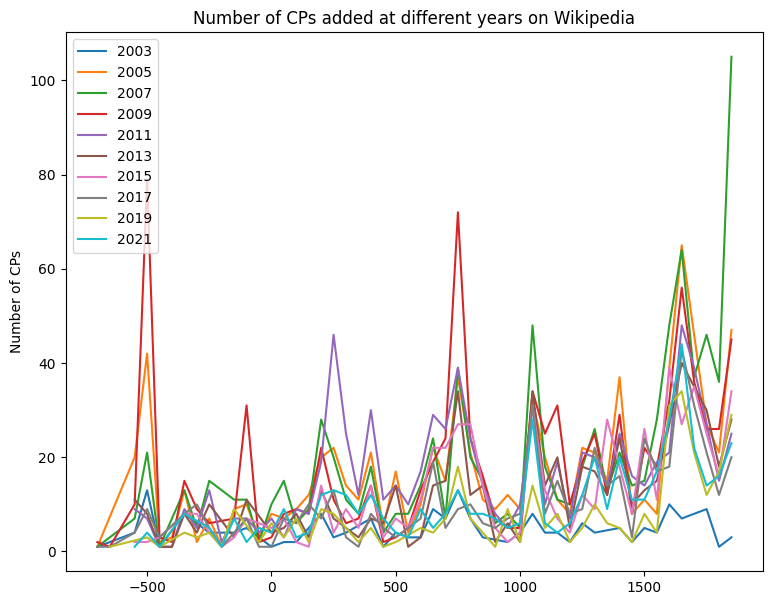

0.7257480954966542

In [14]:
# Load and filter data for 'Low countries' region
df_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
region_name = 'Low countries'
region_name = 'Chinese world'

df_region_fil = df_regions[df_regions
['region_name'] == region_name][['individual_wikidata_id', 'region_name']].copy()

# Merge dataframes to link individuals with their creation years and regions
df_final = pd.merge(df_region_fil, df, on='individual_wikidata_id')

# Calculate productive year and decade for each individual
df_year = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_year['productive_year'] = df_year['birthyear'] + 35
df_year = df_year[['individual_wikidata_id', 'productive_year']].dropna()
df_year['decade'] = df_year['productive_year'].apply(lambda x: round(x / 50) * 50)
df_year = df_year[df_year['decade']<=1880]

# Merge dataframes to link individuals with their productive years and decades
df_final = pd.merge(df_year, df_final, on='individual_wikidata_id')

# Group and count individuals by decade and creation year
df_group = df_final.groupby(['decade', 'creation_year'])['individual_wikidata_id'].count().reset_index()
df_group['creation_year'] = df_group['creation_year'].astype(str)

# Filter the years every 2 years from 2001
years_to_filter = [str(2003 + i*2) for i in range(11)]  # 2001 to 2021
df_group = df_group[df_group['creation_year'].isin(years_to_filter)]

# Plotting
plt.figure(figsize=(9, 7))
for creation_year, group in df_group.groupby('creation_year'):
    plt.plot(group['decade'], group['individual_wikidata_id'], label=f'{creation_year}')

plt.title('Number of CPs added at different years on Wikipedia')
plt.xlabel('')
plt.ylabel('Number of CPs')
plt.legend(loc='upper left')  # Changed to place the legend at the top left
plt.grid(False)

# plt.savefig('figures/wikipedia_stats/evolution_of_creation_year.png', dpi=200)
plt.show()

# Calculate correlation between decades and creation years
df_corr = df_group.pivot(index="decade", columns="creation_year", values='individual_wikidata_id')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()